<a href="https://colab.research.google.com/github/dolevi101/PPKMeans/blob/main/Privacy_Preserving_K_Means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install tenseal
!pip install numpy
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 5.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import copy
import tenseal as ts
import time
import numpy as np
import math
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import itertools
import random

In [4]:
def real_kmeans(n_clusters, data):
    print("real_kmeans...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(np.array(data).reshape(-1, 1))
    labels_data = [0]*len(data)
    labels_centers = [1]*len(kmeans.cluster_centers_)
    labels = labels_data + labels_centers
    X = data + list(kmeans.cluster_centers_)  
    print_fig(X, labels, "real kmeans")
    return kmeans.cluster_centers_

In [6]:
def get_ckks_context():
  # parameters
  #poly_mod_degree = 2**12
  poly_mod_degree = 2**13
  #coeff_mod_bit_sizes = [40, 20, 40]
  coeff_mod_bit_sizes = [35, 25, 25, 25, 25, 25, 25, 25, 25, 35]
  # create TenSEALContext
  context = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
  # scale of ciphertext to use
  #context.global_scale = 2 ** 20
  context.global_scale = 2 ** 25
  # this key is needed for doing dot-product operations
  context.generate_galois_keys()
  return context


def get_other_context():
  # parameters
  #poly_mod_degree = 8192
  poly_mod_degree = 16384
  #poly_mod_degree = 32768
  #coeff_mod_bit_sizes = [40, 21, 21, 21, 21, 21, 21, 40]
  coeff_mod_bit_sizes = [60,35,35,35,35,35,35,35,35,35,60]
  #coeff_mod_bit_sizes = [60,50,50,50,50,50,50,50,50,50,50,50,60]
  print("sum of coeff_mod_bit_sizes=", sum(coeff_mod_bit_sizes))
  # create TenSEALContext
  ctx_training = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
  ctx_training.global_scale = 2 ** 35
  ctx_training.generate_galois_keys()
  return ctx_training


def print_fig(X, centers_colors, plot_name):
    # Create a scatter plot
    fig, axs = plt.subplots(nrows=1, ncols=1)
    axs.scatter(X, [0]*len(X), c=centers_colors)
    axs.set_title(plot_name)
    fig.show()

In [29]:
def our_kmeans(data, centers, n, p, iterations):
    print("our_kmeans...")
    start = time.time()
    probs, p_values_sum = prob_to_be_in_center(data, centers,p,n)
    new_centers = [probs[c_index]/p_values_sum[c_index] for c_index in range(len(centers))]
    end = time.time()

    print("({}/{}) centers = {}, Duration: {} seconds".format(1, iterations, new_centers, end - start))

    for i in range(1, iterations):
        start = time.time()
        probs, p_values_sum = prob_to_be_in_center(data, new_centers,p,n)
        new_centers = [probs[c_index]/p_values_sum[c_index] for c_index in range(len(centers))]
        end = time.time()
        print("({}/{}) centers = {}, Duration: {} seconds".format(i+1, iterations, new_centers, end - start))

    labels_data = [0]*len(data)
    labels_centers = [1]*len(new_centers)
    labels = labels_data + labels_centers
    X = data + new_centers    
    print_fig(X, labels, "our kmeans")

In [30]:
def encrypted_kmeans(data, centers, n, p, iterations):
    print("encrypted_kmeans...")
    context = get_other_context()
    enc_data = [ts.ckks_tensor(context, [item]) for item in data]
    enc_centers = [ts.ckks_tensor(context, [item]) for item in centers]
    
    start = time.time()
    res_probs, res_p_values_sum = prob_to_be_in_center(enc_data, enc_centers,p,n)
    probs, p_values_sum = [item.decrypt().tolist()[0] for item in res_probs], [item.decrypt().tolist()[0] for item in res_p_values_sum]
    
    new_centers = [probs[c_index]/p_values_sum[c_index] for c_index in range(len(centers))]
    end = time.time()

    print("({}/{}) centers = {}, Duration: {} seconds".format(1, iterations, new_centers, end - start))

    for i in range(1, iterations):
        start = time.time()
        enc_data = [ts.ckks_tensor(context, [item]) for item in data]
        enc_centers = [ts.ckks_tensor(context, [item]) for item in new_centers]
        res_probs, res_p_values_sum = prob_to_be_in_center(enc_data, enc_centers,p,n)
        probs = [item.decrypt().tolist()[0] for item in res_probs]
        p_values_sum = [item.decrypt().tolist()[0] for item in res_p_values_sum]
        new_centers = [probs[c_index]/p_values_sum[c_index] for c_index in range(len(centers))]
        end = time.time()
        print("({}/{}) centers = {}, Duration: {} seconds".format(i+1, iterations, new_centers, end - start))

    labels_data = [0]*len(data)
    labels_centers = [1]*len(new_centers)
    labels = labels_data + labels_centers
    X = data + new_centers    
    print_fig(X, labels, "encrypted kmeans")

In [10]:
def max_with_lp(distances, p=20):
  #alpha = ts.plain_tensor(1/p)
  #alpha = 1/p
  #return taylor_series_sqrt_x_plus_1_alpha((x1**p + x2**p+ x3**p+ x4**p) - 1, alpha)
  result_pow = [dist**p for dist in distances]
  return sum(result_pow)
  #return (x1**p + x2**p+ x3**p+ x4**p)


def taylor_series_sqrt_x_plus_1_alpha(x, a):
  sum_elements = 1
  #print("a={}, x={}".format(a,x.data))
  sum_elements += x*a
  sum_elements += 0.5*a*(a-1)*(x**2)
  sum_elements += (1/6)*a*(a-1)*(a-2)*(x**3)
  return sum_elements


def distance(a, b):
  return (a-b)**2


def get_p_value(x, max_val, p,n):
  #approx = approx_to_1_div_x(max_val,n)
  approx = inverse(max_val, n)
  xp = x**p
  #print("xp = {} approx = {}, real = {}".format(xp.decrypt().tolist()[0], approx.decrypt().tolist()[0], (1/(max_val.decrypt().tolist()[0]))))
  #print("x = {}, max_val = {}".format(x, max_val))
  #return xp/max_val
  prob = xp * approx
  return prob
  

#converges only when 0<x<2
def approx_to_1_div_x(x, n):
  #print("x in approx_to_1_div_x is: {}".format(x))
  mul = 1
  for i in range(n):
    mul *= (1+(1-x)**(2**i))
  #print("1/{} = {}".format(x,mul))
  return mul


def inverse(x, n):
    a = 2 - x
    b = 1 - x
    for i in range(n):
        b = b**2
        a = a*(1 + b)
    return a


def normalize_distances(data, centers, n):
  num_of_centers = len(centers)
  num_of_points = len(data)
  dis_before_norm = []
  sum_inv_dis = 0
  for x in data:
      temp_dis_before_norm = []
      for c in centers:
            dis = distance(x, c)
            inv_dis = inverse(dis, n)
            #print("inv_dis = {}".format(inv_dis))
            sum_inv_dis += inv_dis
            temp_dis_before_norm.append(inv_dis)
      dis_before_norm.append(temp_dis_before_norm)
  print(dis_before_norm)
  normalized_dis = []
  for i in range(num_of_points):
    normalized_dis_per_point = []
    for j in range(num_of_centers):
      denominator = inverse(sum_inv_dis, n)
      print("inverse(sum_inv_dis,n) = ",denominator)
      alt_den = 1/sum_inv_dis
      print("1/sum_inv_dis = ",alt_den)
      dis_after_norm = dis_before_norm[i][j] * denominator
      print("dis_after_norm = {}".format(dis_after_norm))
      normalized_dis_per_point.append(dis_after_norm)
    normalized_dis.append(normalized_dis_per_point)

  return normalized_dis


In [41]:
def prob_to_be_in_center(data, centers, p,n):
#  num_of_centers = len(centers)
#  num_of_points = len(data)
#  distances = []
#  sum_distance_p_from_point = []

  
#  normalized_dis = normalize_distances(data, centers, n=1)


#  for i in range(num_of_points):
#      temp_dis = []
#      temp_sum = 0
#      for j in range(num_of_centers):
#            inv_dis = normalized_dis[i][j]
#            temp_dis.append(inv_dis)
#            #temp_dis.append(dis)
#            dis_pow = inv_dis**p
#            #dis_pow = dis**p
#            temp_sum += dis_pow

#      sum_distance_p_from_point.append(temp_sum)
#      distances.append(temp_dis)


  num_of_centers = len(centers)
  num_of_points = len(data)
  #distances = []
  distances_div_k = []
  sum_distance_p_from_point = []
  for x in data:
      #temp_dis = []
      temp_dis_div_k = []
      #temp_sum = 0
      temp_sum_div_k = 0
      for c in centers:
            dis = distance(x, c)
            inv = 1/num_of_centers
            dis_div_k = dis * inv
            #temp_dis.append(dis)
            temp_dis_div_k.append(dis_div_k)
            temp_sum_div_k += dis_div_k
            print("x = {}, c = {}, dis = {}, dis_div_k = {}, temp_sum_div_k = {}".format(x,c, dis, dis_div_k, temp_sum_div_k))
            #dis_pow = dis**p
            #temp_sum += dis_pow

      #sum_distance_p_from_point.append(temp_sum)
      #distances.append(temp_dis)
      all_dis_div_k_per_point = [(temp_sum_div_k - item) for item in temp_dis_div_k]
      print("all_dis_div_k_per_point = ",all_dis_div_k_per_point)
      distances_div_k.append(all_dis_div_k_per_point)
      sum_distance_p_from_point.append(sum([item**p for item in all_dis_div_k_per_point]))
    
  #sum_of_dis = [max(item) for item in distances]
  #print(distances)
  #new_distances = []
  #for i in range(num_of_points):
  #  new_temp_distances = []
  #  for j in range(num_of_centers):
  #    modified_dis = sum_of_dis[i] - distances[i][j]
  #    print("sum_of_dis[i] - distances[i][j] = ", modified_dis)
  #    new_temp_distances.append(modified_dis + 0.0001)
  #  new_distances.append(new_temp_distances) 

  #distances = new_distances

  distances = distances_div_k

  probs = []
  p_values_sum = []
  for i in range(num_of_centers):
    probs_sum = 0
    p_values_sum_per_center = 0
    for j in range(num_of_points):
        #print("distances[j][i] = {}, sum_distance_p_from_point[j] = {}".format(distances[j][i], sum_distance_p_from_point[j]))
        p_value = get_p_value(distances[j][i], sum_distance_p_from_point[j], p,n)
        probs_sum += data[j] * p_value
        #probs_sum += data[j] * (1 - p_value)
        p_values_sum_per_center += p_value
        #p_values_sum_per_center += (1 - p_value)
        if to_print:
          print("@@@@@")
          if is_pp_case:
            #print("point: {}, center: {}, 1 - p_value: {}".format(data[j].decrypt().tolist()[0], centers[i].decrypt().tolist()[0], 1 - p_value.decrypt().tolist()[0]))
            print("point: {}, center: {}, p_value: {}".format(data[j].decrypt().tolist()[0], centers[i].decrypt().tolist()[0], p_value.decrypt().tolist()[0]))
          else:
            #print("point: {}, center: {}, 1 - p_value: {}".format(data[j], centers[i], 1 - p_value))
            print("point: {}, center: {}, p_value: {}".format(data[j], centers[i], p_value))
    probs.append(probs_sum)
    p_values_sum.append(p_values_sum_per_center)
    print("finished center {}/{}".format(i+1, num_of_centers))
  return probs, p_values_sum


In [7]:
static_data = [random.uniform(0,0.2) for i in range(50)] + [random.uniform(0.5,0.9) for i in range(50)]

our_kmeans...
x = 0.1, c = 0.4, dis = 0.09000000000000002, dis_div_k = 0.030000000000000006, temp_sum_div_k = 0.030000000000000006
x = 0.1, c = 0.48, dis = 0.1444, dis_div_k = 0.048133333333333334, temp_sum_div_k = 0.07813333333333333
x = 0.1, c = 0.69, dis = 0.34809999999999997, dis_div_k = 0.11603333333333332, temp_sum_div_k = 0.19416666666666665
all_dis_div_k_per_point =  [0.16416666666666666, 0.14603333333333332, 0.07813333333333333]
x = 0.2, c = 0.4, dis = 0.04000000000000001, dis_div_k = 0.013333333333333336, temp_sum_div_k = 0.013333333333333336
x = 0.2, c = 0.48, dis = 0.07839999999999998, dis_div_k = 0.026133333333333328, temp_sum_div_k = 0.039466666666666664
x = 0.2, c = 0.69, dis = 0.24009999999999992, dis_div_k = 0.0800333333333333, temp_sum_div_k = 0.11949999999999997
all_dis_div_k_per_point =  [0.10616666666666663, 0.09336666666666664, 0.039466666666666664]
x = 0.5, c = 0.4, dis = 0.009999999999999995, dis_div_k = 0.0033333333333333314, temp_sum_div_k = 0.0033333333333333

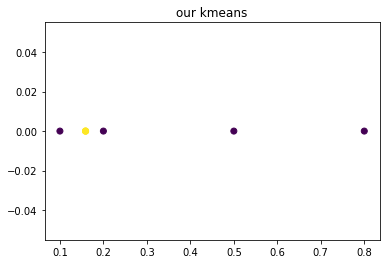

In [42]:
x1 = 0.1
x2 = 0.2
x3 = 0.5
x4 = 0.8
data = [x1, x2, x3, x4]
c1 = 0.4
c2 = 0.48
c3 = 0.69
initial_centers = [c1, c2, c3]

n=3
#p must be even
p=2
iterations = 9
to_print = True

#data = static_data

is_pp_case = False
our_kmeans(data, initial_centers, n, p, iterations)
#real_kmeans(len(initial_centers), data)
is_pp_case = True
#encrypted_kmeans(data, initial_centers, n, p, iterations)